In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, LorentzianModel, VoigtModel

,SC110 out [V],Main in [V],SC110 out [V].1,LI out [a.u.]
0,7.6272,-0.082673,7.6272,-3.0
1,7.6278,-0.082916,7.6278,-2.0
2,7.6285,-0.082673,7.6285,2.0
3,7.6291,-0.082673,7.6291,-5.0
4,7.6298,-0.082916,7.6298,-6.0
...,...,...,...,...
995,8.2911,-0.075878,8.2911,22.0
996,8.2918,-0.076364,8.2918,23.0
997,8.2924,-0.076121,8.2924,18.0
998,8.2932,-0.076121,8.2932,19.0


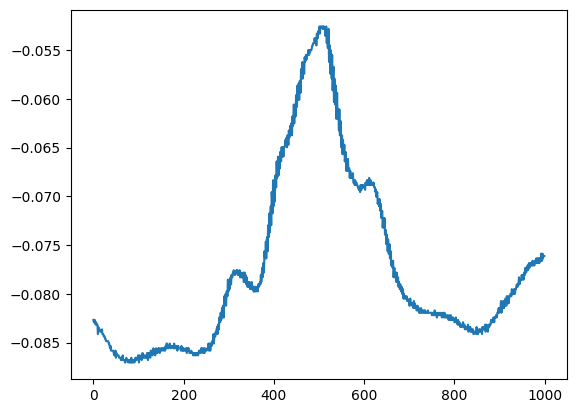

In [40]:
# load data for viz
data = pd.read_csv("Data/SAS_18_03/Pranav/Random/DigiLock-LockData1.txt", sep="\t")
plt.plot(data["Main in [V]"])
data

In [41]:
# load all data

data = np.zeros((30, 1000))
params = np.zeros((30, 3))
for i in range(30):
    temp = np.loadtxt(
        f"Data/SAS_18_03/Pranav/Random/DigiLock-LockData{i+1}.txt",
        skiprows=1,
        delimiter="\t",
    )
    data[i] = temp[:, 1]

[[Model]]
    (((((Model(voigt) + Model(lorentzian, prefix='lz1_')) + Model(lorentzian, prefix='lz2_')) + Model(lorentzian, prefix='lz3_')) + Model(lorentzian, prefix='lz4_')) + Model(lorentzian, prefix='lz5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38000
    # data points      = 1000
    # variables        = 18
    chi-square         = 1.11655694
    reduced chi-square = 0.00113702
    Akaike info crit   = -6761.50549
    Bayesian info crit = -6673.16590
    R-squared          = 0.98485811
##  Warning: uncertainties could not be estimated:
    lz1_amplitude:  at initial value
    lz1_amplitude:  at boundary
[[Variables]]
    amplitude:      0.12723376 (init = 1)
    center:         1.06357919 (init = 0)
    sigma:          0.06795177 (init = 1)
    gamma:          0.06795177 == 'sigma'
    fwhm:           0.24471408 == '1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'
    height:         0.39078991 == '(amplitude/(max(1e-15, sigma*sqrt(2*pi)

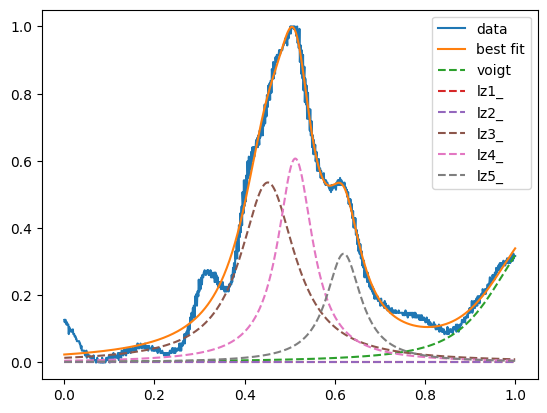

In [42]:
# curve fitting lorentzians to a background of voigt profile
ydat = data[0]
ydat -= np.min(ydat)
ydat /= np.max(ydat)  # normalising

xdat = np.linspace(0, 1, 1000)


def add_peak(prefix, center, amplitude=0.005, sigma=0.05):
    peak = LorentzianModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + "center"].set(center)
    pars[prefix + "amplitude"].set(amplitude, min=0.01, max=0.5)
    pars[prefix + "sigma"].set(sigma, min=0)
    return peak, pars


model = VoigtModel()
params = model.make_params()
rough_peak_positions = (0.1, 0.2, 0.4, 0.5, 0.61)
for i, cen in enumerate(rough_peak_positions):
    peak, pars = add_peak("lz%d_" % (i + 1), cen)
    model = model + peak
    params.update(pars)
init = model.eval(params, x=xdat)
result = model.fit(ydat, params, x=xdat)
comps = result.eval_components()

print(result.fit_report(min_correl=0.5))

plt.plot(xdat, ydat, label="data")
plt.plot(xdat, result.best_fit, label="best fit")
for name, comp in comps.items():
    plt.plot(xdat, comp, "--", label=name)
plt.legend(loc="upper right")
plt.show()
# you can use the result object to get the parameters of the fit
res = result.params

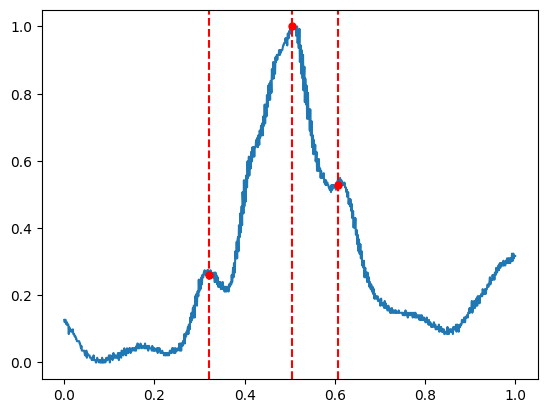

In [43]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

plt.plot(xdat, ydat)
ydat_smooth = gaussian_filter1d(ydat, 10)
peaks, _ = find_peaks(ydat_smooth, height=0.1)
plt.plot(xdat[peaks], ydat[peaks], "ro", ms=5)
for peak in peaks:
    if peak > 700:
        break
    plt.axvline(x=xdat[peak], color="r", linestyle="--")
plt.show()

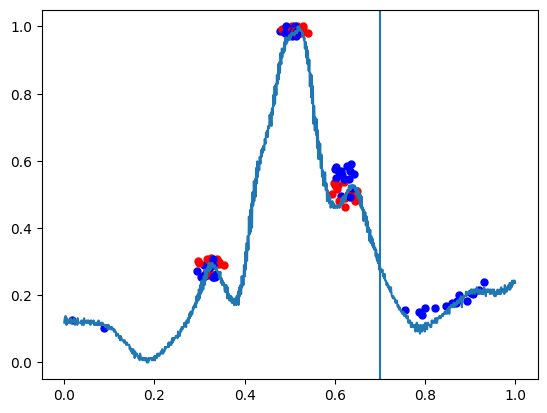

In [44]:
for i in data:
    ydat = i
    ydat -= np.min(ydat)
    ydat /= np.max(ydat)  # normalising

    ydat_smooth = gaussian_filter1d(ydat, 10)
    peaks, _ = find_peaks(ydat_smooth, height=0.1)
    if len(peaks) < 4:
        plt.plot(xdat[peaks], ydat[peaks], "ro", ms=5)

    if len(peaks) > 3:
        plt.plot(
            xdat[peaks], ydat[peaks], "bo", ms=5
        )  # locations of the clusters of the peaks
plt.axvline(0.7)
plt.plot(xdat, ydat)
# here, for CNN annotation we would require additional data such as linewidths, amplitudes, etc.

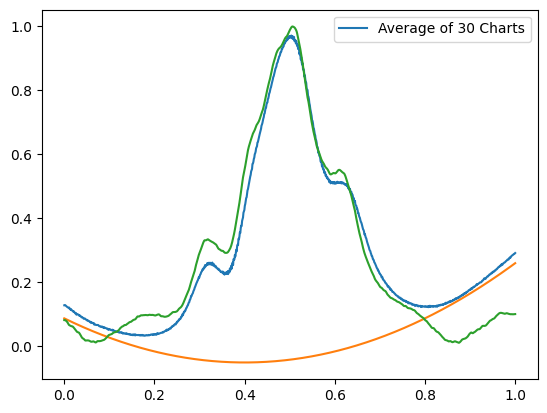

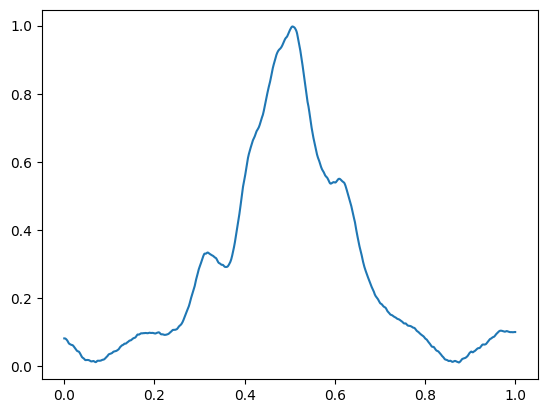

In [45]:
avg_data = np.mean(data, axis=0)
plt.plot(xdat, avg_data, label="Average of 30 Charts")
plt.legend()

# plot a quadratic
x = np.linspace(0, 1, 100)
y = 0.86 * (xdat - 0.4) ** 2 - 0.05
plt.plot(xdat, y)

new_data = data[0] - y
# min max scaling
new_data -= np.min(new_data)
new_data /= np.max(new_data)

# smoothing
new_data = gaussian_filter1d(new_data, 2)

plt.plot(xdat, new_data)
plt.show()

plt.plot(xdat, new_data)

[[Model]]
    (((((Model(lorentzian, prefix='lz0_') + Model(lorentzian, prefix='lz1_')) + Model(lorentzian, prefix='lz2_')) + Model(lorentzian, prefix='lz3_')) + Model(lorentzian, prefix='lz4_')) + Model(lorentzian, prefix='lz5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1174
    # data points      = 1000
    # variables        = 18
    chi-square         = 1.46983620
    reduced chi-square = 0.00149678
    Akaike info crit   = -6486.60431
    Bayesian info crit = -6398.26472
    R-squared          = 0.97804114
##  Warning: uncertainties could not be estimated:
    lz2_amplitude:  at boundary
[[Variables]]
    lz0_amplitude:  0.06334671 (init = 1)
    lz0_center:     0.95882194 (init = 0)
    lz0_sigma:      0.10043151 (init = 1)
    lz0_fwhm:       0.20086302 == '2.0000000*lz0_sigma'
    lz0_height:     0.20077250 == '0.3183099*lz0_amplitude/max(1e-15, lz0_sigma)'
    lz1_amplitude:  0.01782522 (init = 0.005)
    lz1_center:     0.03655734 (init = 

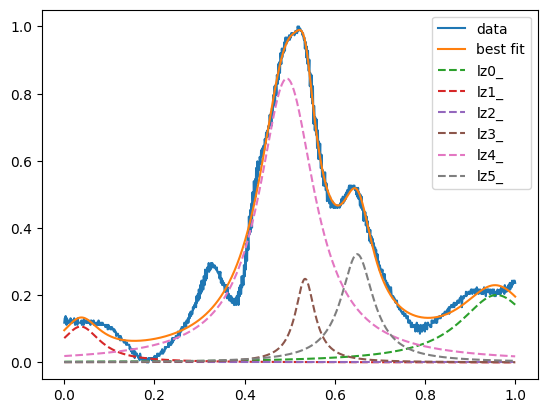

In [46]:
# fit 6 lorentzians using the LMFIT model to the new data


def add_peak(prefix, center, amplitude=0.005, sigma=0.05):
    peak = LorentzianModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + "center"].set(center)
    pars[prefix + "amplitude"].set(amplitude, min=0)
    pars[prefix + "sigma"].set(sigma, min=0)
    return peak, pars


rough_peak_positions = (0.1, 0.2, 0.3, 0.4, 0.7)
model = LorentzianModel(prefix="lz0_")
params = model.make_params()
for i, cen in enumerate(rough_peak_positions):
    peak, pars = add_peak("lz%d_" % (i + 1), cen)
    model = model + peak
    params.update(pars)
init = model.eval(params, x=xdat)
result = model.fit(ydat, params, x=xdat)
comps = result.eval_components()

print(result.fit_report(min_correl=0.5))

plt.plot(xdat, ydat, label="data")
plt.plot(xdat, result.best_fit, label="best fit")
for name, comp in comps.items():
    plt.plot(xdat, comp, "--", label=name)
plt.legend(loc="upper right")
plt.show()

[[Model]]
    (((((Model(lorentzian, prefix='lz0_') + Model(lorentzian, prefix='lz1_')) + Model(lorentzian, prefix='lz2_')) + Model(lorentzian, prefix='lz3_')) + Model(lorentzian, prefix='lz4_')) + Model(lorentzian, prefix='lz5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1197
    # data points      = 1000
    # variables        = 18
    chi-square         = 0.26132349
    reduced chi-square = 2.6611e-04
    Akaike info crit   = -8213.75149
    Bayesian info crit = -8125.41189
    R-squared          = 0.99676863
##  Warning: uncertainties could not be estimated:
    lz1_amplitude:  at boundary
[[Variables]]
    lz0_amplitude:  0.00797197 (init = 1)
    lz0_center:     0.97024205 (init = 0)
    lz0_sigma:      0.03211206 (init = 1)
    lz0_fwhm:       0.06422412 == '2.0000000*lz0_sigma'
    lz0_height:     0.07902194 == '0.3183099*lz0_amplitude/max(1e-15, lz0_sigma)'
    lz1_amplitude:  1.4928e-12 (init = 0.005)
    lz1_center:     0.22711573 (init = 

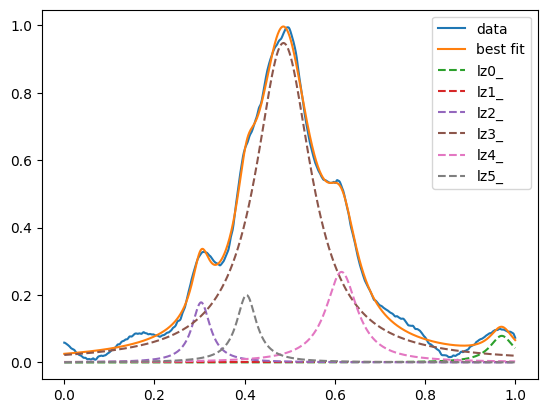

In [49]:
new_data = data[7] - y
# min max scaling
new_data -= np.min(new_data)
new_data /= np.max(new_data)

# smoothing
new_data = gaussian_filter1d(new_data, 2)

result = model.fit(new_data, params, x=xdat)
comps = result.eval_components()

print(result.fit_report(min_correl=0.5))

plt.plot(xdat, new_data, label="data")
plt.plot(xdat, result.best_fit, label="best fit")
for name, comp in comps.items():
    plt.plot(xdat, comp, "--", label=name)
plt.legend(loc="upper right")
plt.show()

In [48]:
# prepare the data for the CNN
# check the fit manually
for i in range(30):
    new_data = data[i] - y
    result = model.fit(new_data, params, x=xdat)
    res = result.fit_report(min_correl=0.5)
    # Example string
    key = "R-squared"
    position = res.find(key)
    if position != -1:
        print(res[position : position + 30])
    else:
        print(f"'{key}' not found in the text")

R-squared          = 0.9948939
R-squared          = 0.9963821
R-squared          = 0.9928726
R-squared          = 0.9958192
R-squared          = 0.9904010
R-squared          = 0.9942893
R-squared          = 0.9942298
R-squared          = 0.9913820
R-squared          = 0.9966014
R-squared          = 0.9951327
R-squared          = 0.9881827
R-squared          = 0.9940239
R-squared          = 0.9932685
R-squared          = 0.9874245
R-squared          = 0.9960444
R-squared          = 0.9965138
R-squared          = 0.9951589
R-squared          = 0.9956369
R-squared          = 0.9935680
R-squared          = 0.9959871
R-squared          = 0.9959236
R-squared          = 0.9958246
R-squared          = 0.9946861
R-squared          = 0.9964944
R-squared          = 0.9959477
R-squared          = 0.9937365
R-squared          = 0.9915908
R-squared          = 0.9953537
R-squared          = 0.9964054
R-squared          = 0.9963082
